# Masksemble Layer aided Cross-ViT for Medical Image Segmentation

### Importing important modules

In [1]:
import numpy as np
import torch
import torchvision.models as models
from torchvision.ops import Conv2dNormActivation
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader
import torch.nn as nn
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.layers import to_2tuple,to_3tuple,DropPath,Mlp
from torchvision import transforms,datasets
from PIL import Image
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from einops.layers.torch import Rearrange
from einops import rearrange,repeat
import shutil
import pandas as pd
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import seaborn as sns
from operator import truediv
import sys
from PIL import Image
from torchcam.methods import SmoothGradCAMpp,CAM,GradCAM
from masksembles.torch import Masksembles1D,Masksembles2D
import tensorflow as tf

In [2]:
class modified_conv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.c1 = self.c = Conv2dNormActivation(in_channels,8,kernel_size=3,stride=1,padding=1,activation_layer=nn.RReLU)
        self.c2 = self.c = Conv2dNormActivation(8,out_channels,kernel_size=3,stride=1,padding=1,activation_layer=nn.RReLU)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)

    def forward(self,x):
        x = self.c1(x)
        x = self.pool1(x)
        x = self.c2(x)
        x = self.pool1(x)
        return x

In [3]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.25):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [4]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

In [5]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [6]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.1):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d',h=h), qkv)

        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [7]:
class CrossAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_k = nn.Linear(dim, inner_dim , bias=False)
        self.to_v = nn.Linear(dim, inner_dim , bias = False)
        self.to_q = nn.Linear(dim, inner_dim, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x_qkv):
        b, n, _, h = *x_qkv.shape, self.heads

        k = self.to_k(x_qkv)
        k = rearrange(k, 'b n (h d) -> b h n d', h = h)

        v = self.to_v(x_qkv)
        v = rearrange(v, 'b n (h d) -> b h n d', h = h)

        q = self.to_q(x_qkv[:, 0].unsqueeze(1))
        q = rearrange(q, 'b n (h d) -> b h n d', h = h)



        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [8]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, MLP(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


In [9]:
class MultiScaleTransformerEncoder(nn.Module):

    def __init__(self, small_dim = 28, small_depth = 4, small_heads =3, small_dim_head = 32, small_mlp_dim = 384,
                 large_dim = 56, large_depth = 1, large_heads = 3, large_dim_head = 64, large_mlp_dim = 768,
                 cross_attn_depth = 1, cross_attn_heads = 3, dropout = 0.):
        super().__init__()
        self.transformer_enc_small = Transformer(small_dim, small_depth, small_heads, small_dim_head, small_mlp_dim)
        self.transformer_enc_large = Transformer(large_dim, large_depth, large_heads, large_dim_head, large_mlp_dim)

        self.cross_attn_layers = nn.ModuleList([])
        for _ in range(cross_attn_depth):
            self.cross_attn_layers.append(nn.ModuleList([
                nn.Linear(small_dim, large_dim),
                nn.Linear(large_dim, small_dim),
                PreNorm(large_dim, CrossAttention(large_dim, heads = cross_attn_heads, dim_head = large_dim_head, dropout = dropout)),
                nn.Linear(large_dim, small_dim),
                nn.Linear(small_dim, large_dim),
                PreNorm(small_dim, CrossAttention(small_dim, heads = cross_attn_heads, dim_head = small_dim_head, dropout = dropout)),
            ]))

    def forward(self, xs, xl):

        xs = self.transformer_enc_small(xs)
        xl = self.transformer_enc_large(xl)

        for f_sl, g_ls, cross_attn_s, f_ls, g_sl, cross_attn_l in self.cross_attn_layers:
            small_class = xs[:, 0]
            x_small = xs[:, 1:]
            large_class = xl[:, 0]
            x_large = xl[:, 1:]

            # Cross Attn for Large Patch

            cal_q = f_ls(large_class.unsqueeze(1))
            cal_qkv = torch.cat((cal_q, x_small), dim=1)
            cal_out = cal_q + cross_attn_l(cal_qkv)
            cal_out = g_sl(cal_out)
            xl = torch.cat((cal_out, x_large), dim=1)

            # Cross Attn for Smaller Patch
            cal_q = f_sl(small_class.unsqueeze(1))
            cal_qkv = torch.cat((cal_q, x_large), dim=1)
            cal_out = cal_q + cross_attn_s(cal_qkv)
            cal_out = g_ls(cal_out)
            xs = torch.cat((cal_out, x_small), dim=1)

        return xs, xl

In [10]:
class CrossViTm(nn.Module):
    def __init__(self, image_size, channels, num_classes, patch_size_small = 7, patch_size_large = 8, small_dim = 28,
                 large_dim = 56, small_depth = 1, large_depth = 4, cross_attn_depth = 1, multi_scale_enc_depth = 3,
                 heads = 4, pool = 'cls', dropout = 0., emb_dropout = 0., scale_dim = 4):
        super().__init__()
        #self.c = Conv2dNormActivation(channels,3,kernel_size=3,stride=1,padding=1,activation_layer=nn.RReLU)
        #self.pool_i = nn.AvgPool2d(kernel_size=3,stride=3)
        self.conv = nn.Sequential(
            modified_conv(channels,32)
        )

        self.mask_layer_2d = Masksembles2D(channels=32,n=4,scale=2.)
        self.mask_layer_1d1 = Masksembles1D(channels=28,n=4,scale=2.)
        self.mask_layer_1d2 = Masksembles1D(channels=56,n=4,scale=2.)
        assert image_size % patch_size_small == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches_small = (image_size // patch_size_small) ** 2
        patch_dim_small = 32 * patch_size_small ** 2 #channels

        assert image_size % patch_size_large == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches_large = (image_size // patch_size_large) ** 2
        patch_dim_large = 32 * patch_size_large ** 2 #channels
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'


        self.to_patch_embedding_small = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size_small, p2 = patch_size_small),
            nn.Linear(patch_dim_small, small_dim),
        )

        self.to_patch_embedding_large = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size_large, p2=patch_size_large),
            nn.Linear(patch_dim_large, large_dim),
        )

        self.pos_embedding_small = nn.Parameter(torch.randn(1, num_patches_small + 1, small_dim))
        self.cls_token_small = nn.Parameter(torch.randn(1, 1, small_dim))
        self.dropout_small = nn.Dropout(emb_dropout)

        self.pos_embedding_large = nn.Parameter(torch.randn(1, num_patches_large + 1, large_dim))
        self.cls_token_large = nn.Parameter(torch.randn(1, 1, large_dim))
        self.dropout_large = nn.Dropout(emb_dropout)

        self.multi_scale_transformers = nn.ModuleList([])
        for _ in range(multi_scale_enc_depth):
            self.multi_scale_transformers.append(MultiScaleTransformerEncoder(small_dim=small_dim, small_depth=small_depth,
                                                                              small_heads=heads, small_dim_head=small_dim//heads,
                                                                              small_mlp_dim=small_dim*scale_dim,
                                                                              large_dim=large_dim, large_depth=large_depth,
                                                                              large_heads=heads, large_dim_head=large_dim//heads,
                                                                              large_mlp_dim=large_dim*scale_dim,
                                                                              cross_attn_depth=cross_attn_depth, cross_attn_heads=heads,
                                                                              dropout=dropout))

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head_small = nn.Sequential(
            nn.LayerNorm(small_dim),
            nn.Linear(small_dim, num_classes)
        )

        self.mlp_head_large = nn.Sequential(
            nn.LayerNorm(large_dim),
            nn.Linear(large_dim, num_classes)
        )


    def forward(self, img):
        #img = self.c(img)
        #img = self.pool_i(img)
        img = self.conv(img)
        img = self.mask_layer_2d(img)
        print(img.shape)
        xs = self.to_patch_embedding_small(img)
        b, n, _ = xs.shape

        cls_token_small = repeat(self.cls_token_small, '() n d -> b n d', b = b)
        xs = torch.cat((cls_token_small, xs), dim=1)
        xs += self.pos_embedding_small[:, :(n + 1)]
        xs = self.dropout_small(xs)

        xl = self.to_patch_embedding_large(img)
        b, n, _ = xl.shape

        cls_token_large = repeat(self.cls_token_large, '() n d -> b n d', b=b)
        xl = torch.cat((cls_token_large, xl), dim=1)
        xl += self.pos_embedding_large[:, :(n + 1)]
        xl = self.dropout_large(xl)

        for multi_scale_transformer in self.multi_scale_transformers:
            xs, xl = multi_scale_transformer(xs, xl)
        
        xs = xs.mean(dim = 1) if self.pool == 'mean' else xs[:, 0]
        xl = xl.mean(dim = 1) if self.pool == 'mean' else xl[:, 0]
        # xs = self.mask_layer_1d1(xs)
        # xl = self.mask_layer_1d2(xl)
        # xs = xs.float()
        # xl = xl.float()
        xs = self.mlp_head_small(xs)
        xl = self.mlp_head_large(xl)
        x = xs + xl
        return x

In [51]:
# img = torch.ones([40, 3, 224, 224])

# model = CrossViT(224, 3, 2)

# parameters = filter(lambda p: p.requires_grad, model.parameters())
# parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
# print('Trainable Parameters: %.3fM' % parameters)

# out = model(img)
# print("Shape of out :", out.shape)

Trainable Parameters: 0.789M
torch.Size([40, 32, 56, 56])
Shape of out : torch.Size([40, 2])


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
torch.manual_seed(0)
np.random.seed(0)

In [13]:
mean, std = (0.1,), (0.1,)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                              ])

In [14]:
train_data = datasets.ImageFolder('train',transform=transform)
valid_data = datasets.ImageFolder('test',transform=transform)

In [15]:
train_data.class_to_idx

{'benign': 0, 'malignant': 1}

In [16]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=40, shuffle=True)


In [17]:
validloader = torch.utils.data.DataLoader(valid_data, batch_size=40, shuffle=False)

In [19]:
trainloader.dataset

Dataset ImageFolder
    Number of datapoints: 2600
    Root location: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [20]:
import matplotlib.pyplot as plt

torch.Size([32, 3, 224, 224])


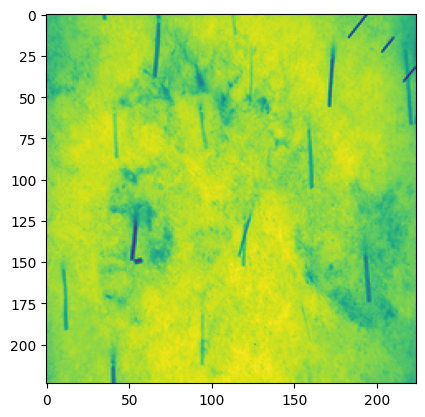

In [47]:
for img, label in trainloader:
    # x = a(img)
    # print(x.shape)
    plt.imshow(img[12][0])
    print(img.shape)
    break

In [18]:
model = CrossViTm(224, 3, 2).to(device)

In [19]:
model

CrossViTm(
  (conv): Sequential(
    (0): hetconv(
      (c1): Conv2dNormActivation(
        (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
      )
      (c): Conv2dNormActivation(
        (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
      )
      (c2): Conv2dNormActivation(
        (0): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): RReLU(lower=0.125, upper=0.3333333333333333, inplace=True)
      )
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [29]:
loss_hist = {}
loss_hist["train accuracy"] = []
loss_hist["train loss"] = []

for epoch in range(1, 5+1):
    model.train()
    
    epoch_train_loss = 0
        
    y_true_train = []
    y_pred_train = []
        
    for batch_idx, (img, labels) in enumerate(trainloader):
        img = img.to(device)
        labels = labels.to(device)
        
        preds = model(img)
        
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())
          
        epoch_train_loss += loss.item()
    
    loss_hist["train loss"].append(epoch_train_loss)
    
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    
    loss_hist["train accuracy"].append(accuracy)
    
    print("-------------------------------------------------")
    print("Epoch: {} Train mean loss: {:.8f}".format(epoch, epoch_train_loss))
    print("       Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------") #15

-------------------------------------------------
Epoch: 1 Train mean loss: 17.04884861
       Train Accuracy%:  88.11538461538461 == 2291 / 2600
-------------------------------------------------
-------------------------------------------------
Epoch: 2 Train mean loss: 17.18486037
       Train Accuracy%:  88.42307692307692 == 2299 / 2600
-------------------------------------------------
-------------------------------------------------
Epoch: 3 Train mean loss: 15.99752270
       Train Accuracy%:  88.88461538461539 == 2311 / 2600
-------------------------------------------------
-------------------------------------------------
Epoch: 4 Train mean loss: 15.75581995
       Train Accuracy%:  89.07692307692308 == 2316 / 2600
-------------------------------------------------
-------------------------------------------------
Epoch: 5 Train mean loss: 16.28971580
       Train Accuracy%:  89.07692307692308 == 2316 / 2600
-------------------------------------------------


In [31]:
torch.save(model.state_dict(),'model/crossViT_masksemble2d.pth')

In [20]:
# model.load_state_dict(torch.load('model/crossViT_masksemble2d.pth'))

<All keys matched successfully>

In [31]:
import torch.nn.functional as nnf

In [44]:
y_true_test = []
y_pred_test = []
y_pred_prob = []
with torch.no_grad():
    model.eval()
    
    
    
    for batch_idx, (img, labels) in enumerate(validloader):
        img = img.to(device)
        label = labels.to(device)
        preds = model(img)
        s = nn.Softmax(dim=-1)
        out = s(preds)
        # top_p, top_class = prob.topk(1, dim = 1)
        # print(out.detach().tolist())
        y_pred_prob.extend(out.detach().tolist())
        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(labels.detach().tolist())
    total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
    total = len(y_pred_test)
    accuracy = total_correct * 100 / total
    
    print("Test Accuracy%: ", accuracy, "==", total_correct, "/", total)

torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([40, 32, 56, 56])
torch.Size([20, 32, 56, 56])
Test Accuracy%:  85.75757575757575 == 566 / 660


In [24]:
def get_confusion_matrix(y_test,y_pred, plt_name):
    # Create a confusion matrix as a Pandas dataframe with 6 classes
    df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
    # Rename the columns to match the class names
    df_cm.columns = ['benign','malignant']
    # Rename the index to 'Actual'
    df_cm = df_cm.rename({0:'benign',1:'malignant'})
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    # Set the font size for the labels in the heatmap
    sns.set(font_scale=0.9)#for label size
    # Create a heatmap of the confusion matrix using seaborn
    sns.heatmap(df_cm, cmap="Blues",annot=True,annot_kws={"size": 16}, fmt='g')
    # Save the plot as an eps file with the given name
    plt.savefig('cmetrics/'+str(plt_name)+'.eps', format='eps')

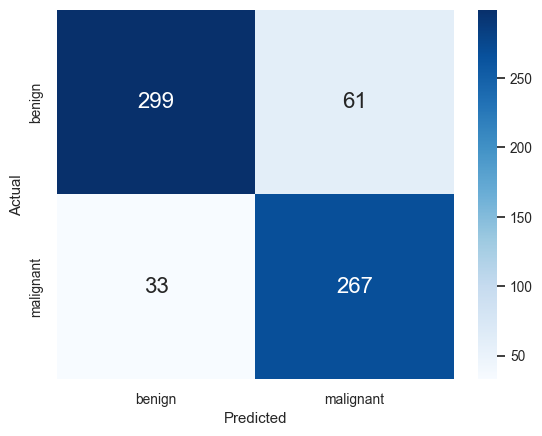

In [25]:
get_confusion_matrix(y_true_test,y_pred_test,'Cross_ViT_masksemble')

In [26]:
cm = confusion_matrix(y_pred_test,y_true_test)

In [27]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    # Compute the diagonal of the confusion matrix, which contains the number of true positives
    list_diag = np.diag(confusion_matrix)
    # Compute the row sums of the confusion matrix, which contain the number of samples in each class
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    # Compute the accuracy for each class, ignoring NaNs (which occur when the class has no samples in the test set)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    # Compute the average accuracy across all classes
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [28]:
each_class,avg = AA_andEachClassAccuracy(cm)

In [31]:
from sklearn.manifold import TSNE

In [32]:
def gen_features():
    model.eval()
    targets_list = []
    outputs_list = []

    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(trainloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets_np = targets.data.cpu().numpy()

            outputs = model(inputs)
            outputs_np = outputs.data.cpu().numpy()
            
            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)
            
            if ((idx+1) % 10 == 0) or (idx+1 == len(trainloader)):
                print(idx+1, '/', len(trainloader))

    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

    return targets, outputs

In [33]:
target,output = gen_features()

10 / 65
20 / 65
30 / 65
40 / 65
50 / 65
60 / 65
65 / 65


In [34]:
import os

In [35]:
def tsne_plot(save_dir, targets, outputs):
    print('generating t-SNE plot...')
    tsne = TSNE(random_state=0)
    tsne_output = tsne.fit_transform(outputs)

    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    df['targets'] = targets

    plt.rcParams['figure.figsize'] = 10, 10
    sns.scatterplot(
        x='x', y='y',
        hue='targets',
        palette=sns.dark_palette("green",n_colors=2),
        #palette=sns.color_palette("hls", 5),
        data=df,
        s=400,
        #markers={"all":'o',"hem":'o'},
        #style='targets',
        legend=False,
        alpha=1
    )

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')

    plt.savefig(os.path.join(save_dir,'crossViT_masksemble.eps'), bbox_inches='tight')
    print('done!')

generating t-SNE plot...
done!


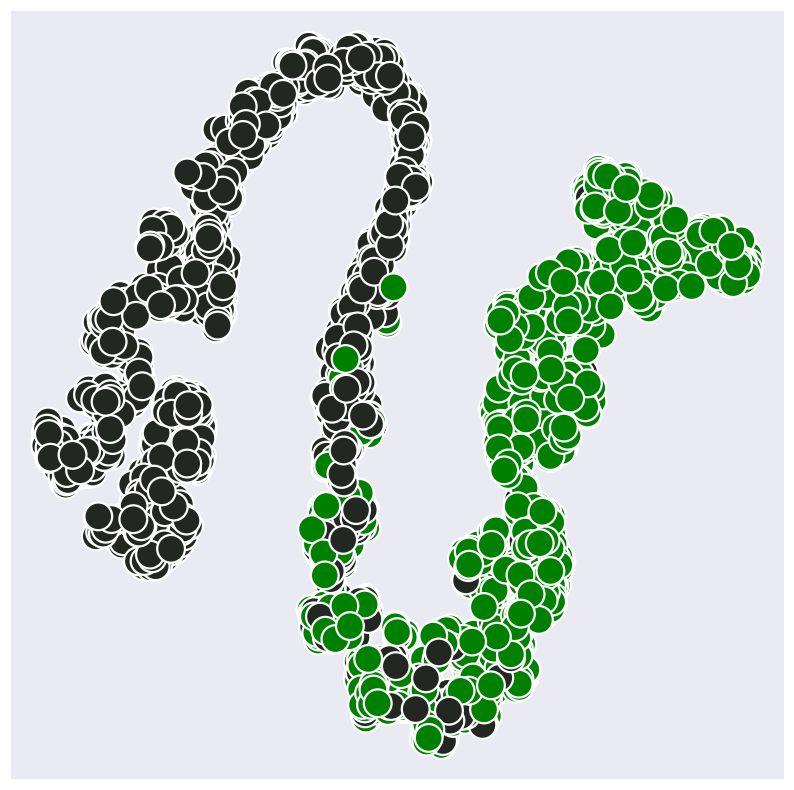

In [36]:
tsne_plot('tsne', target, output)

In [34]:
img = Image.open("data/test/malignant/52.jpg")
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.CenterCrop(224),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                              ])
img = transform(img)
img = img.reshape(1,3,224,224)
inputs = np.tile(img[None], [4, 1, 1, 1])
inputs = torch.from_numpy(inputs)
inputs = inputs.to(device)
s = nn.Softmax(dim=-1)
out = model(inputs[0])
out_new = out.cpu().tolist()
y = np.arange(4)


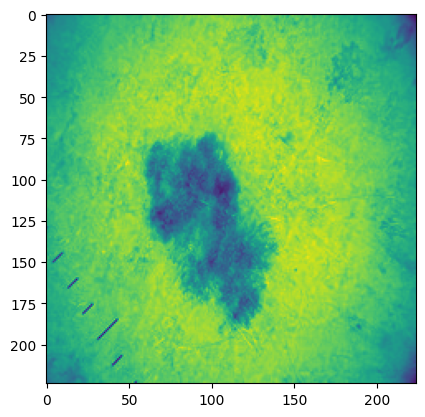

In [40]:
import matplotlib.pyplot as plt
plt.imshow(inputs[0][3][0])

In [25]:
original_images=[]
import os
from os import listdir
folder_dir = "chart"
for images in os.listdir(folder_dir):

	image = Image.open('chart/'+images)
	original_images.append(image)

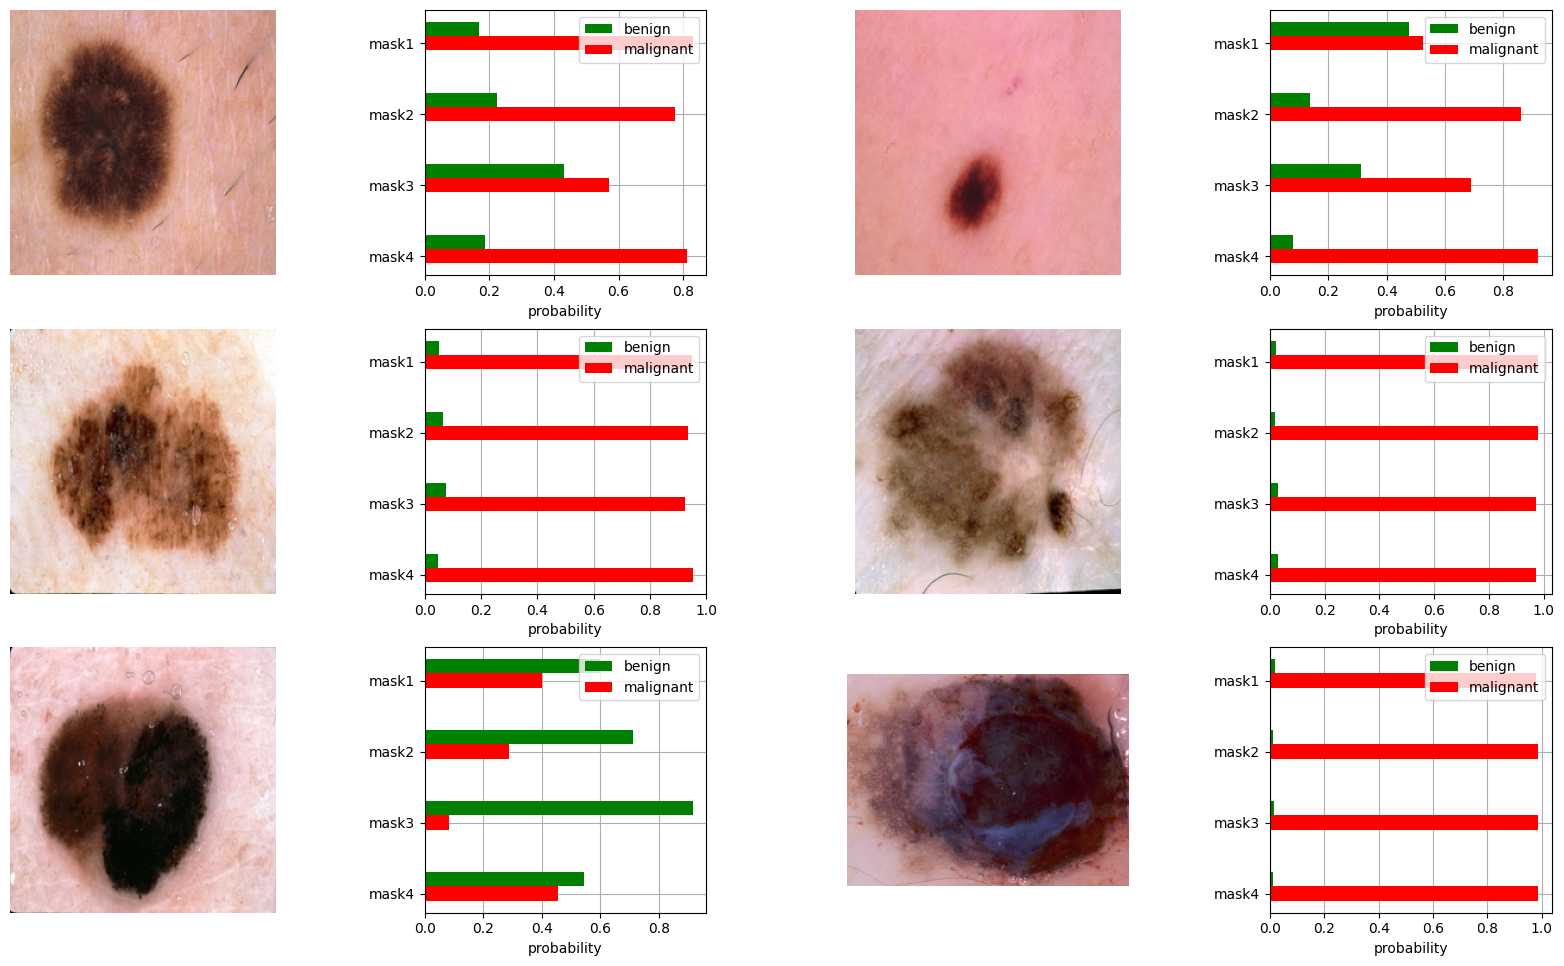

In [26]:
plt.figure(figsize=(20, 20))
for i, image in enumerate(original_images):
    plt.subplot(5, 4, 2 * i + 1)
    transform = transforms.Compose([transforms.ToTensor(),
                                transforms.CenterCrop(224),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                              ])
    img = transform(image)
    img = img.reshape(1,3,224,224)
    inputs = np.tile(img[None], [4, 1, 1, 1])
    inputs = torch.from_numpy(inputs)
    inputs = inputs.to(device)
    s = nn.Softmax(dim=-1)
    out = s(model(inputs[0])).cpu().tolist()
    plt.imshow(image)
    plt.axis("off")
    plt.subplot(5, 4, 2 * i + 2)
    #y = np.arange(4)
    plt.grid()
    d = pd.DataFrame(dict(graph=['mask1', 'mask2', 'mask3', 'mask4'],
                           n=[out[0][0], out[1][0], out[2][0], out[3][0]], m=[out[0][1], out[1][1], out[2][1], out[3][1]]))
    width = 0.2
    y = np.arange(4)
    #fig, ax = plt.subplots()
    plt.barh(y, d.n, width, color='green', label='benign')
    plt.barh(y + width, d.m, width, color='red', label='malignant')
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y + width, d.graph)
    plt.xlabel("probability")
    plt.legend()
    #plt.imshow(image)
    #break

plt.subplots_adjust(wspace=0.5)
plt.savefig('comparison/masksemble_data'+'.pdf', format='pdf')
plt.show()

In [37]:
for i, cls in enumerate(torch.argmax(out, axis=1)):
    print(f"PREDICTION OF {i+1} MODEL: {cls} CLASS")

PREDICTION OF 1 MODEL: 1 CLASS
PREDICTION OF 2 MODEL: 1 CLASS
PREDICTION OF 3 MODEL: 1 CLASS
PREDICTION OF 4 MODEL: 1 CLASS


## Cross-ViT with modified conv

In [21]:
import numpy as np
import torch
import torchvision.models as models
from torchvision.ops import Conv2dNormActivation
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader
import torch.nn as nn
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.layers import to_2tuple,to_3tuple,DropPath,Mlp
from torchvision import transforms,datasets
from PIL import Image
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from einops.layers.torch import Rearrange
from einops import rearrange,repeat
import shutil
import pandas as pd
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import seaborn as sns
from operator import truediv
import sys
from PIL import Image
from torchcam.methods import SmoothGradCAMpp,CAM,GradCAM
from masksembles.torch import Masksembles1D,Masksembles2D
import tensorflow as tf

In [22]:
class modified_conv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.c1 = self.c = Conv2dNormActivation(in_channels,8,kernel_size=3,stride=1,padding=1,activation_layer=nn.RReLU)
        self.c2 = self.c = Conv2dNormActivation(8,out_channels,kernel_size=3,stride=1,padding=1,activation_layer=nn.RReLU)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)

    def forward(self,x):
        x = self.c1(x)
        x = self.pool1(x)
        x = self.c2(x)
        x = self.pool1(x)
        return x

In [23]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.25):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [24]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

In [25]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [26]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.1):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d',h=h), qkv)

        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [27]:
class CrossAttention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_k = nn.Linear(dim, inner_dim , bias=False)
        self.to_v = nn.Linear(dim, inner_dim , bias = False)
        self.to_q = nn.Linear(dim, inner_dim, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x_qkv):
        b, n, _, h = *x_qkv.shape, self.heads

        k = self.to_k(x_qkv)
        k = rearrange(k, 'b n (h d) -> b h n d', h = h)

        v = self.to_v(x_qkv)
        v = rearrange(v, 'b n (h d) -> b h n d', h = h)

        q = self.to_q(x_qkv[:, 0].unsqueeze(1))
        q = rearrange(q, 'b n (h d) -> b h n d', h = h)



        dots = torch.einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [28]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, MLP(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


In [29]:
class MultiScaleTransformerEncoder(nn.Module):

    def __init__(self, small_dim = 28, small_depth = 4, small_heads =3, small_dim_head = 32, small_mlp_dim = 384,
                 large_dim = 56, large_depth = 1, large_heads = 3, large_dim_head = 64, large_mlp_dim = 768,
                 cross_attn_depth = 1, cross_attn_heads = 3, dropout = 0.):
        super().__init__()
        self.transformer_enc_small = Transformer(small_dim, small_depth, small_heads, small_dim_head, small_mlp_dim)
        self.transformer_enc_large = Transformer(large_dim, large_depth, large_heads, large_dim_head, large_mlp_dim)

        self.cross_attn_layers = nn.ModuleList([])
        for _ in range(cross_attn_depth):
            self.cross_attn_layers.append(nn.ModuleList([
                nn.Linear(small_dim, large_dim),
                nn.Linear(large_dim, small_dim),
                PreNorm(large_dim, CrossAttention(large_dim, heads = cross_attn_heads, dim_head = large_dim_head, dropout = dropout)),
                nn.Linear(large_dim, small_dim),
                nn.Linear(small_dim, large_dim),
                PreNorm(small_dim, CrossAttention(small_dim, heads = cross_attn_heads, dim_head = small_dim_head, dropout = dropout)),
            ]))

    def forward(self, xs, xl):

        xs = self.transformer_enc_small(xs)
        xl = self.transformer_enc_large(xl)

        for f_sl, g_ls, cross_attn_s, f_ls, g_sl, cross_attn_l in self.cross_attn_layers:
            small_class = xs[:, 0]
            x_small = xs[:, 1:]
            large_class = xl[:, 0]
            x_large = xl[:, 1:]

            # Cross Attn for Large Patch

            cal_q = f_ls(large_class.unsqueeze(1))
            cal_qkv = torch.cat((cal_q, x_small), dim=1)
            cal_out = cal_q + cross_attn_l(cal_qkv)
            cal_out = g_sl(cal_out)
            xl = torch.cat((cal_out, x_large), dim=1)

            # Cross Attn for Smaller Patch
            cal_q = f_sl(small_class.unsqueeze(1))
            cal_qkv = torch.cat((cal_q, x_large), dim=1)
            cal_out = cal_q + cross_attn_s(cal_qkv)
            cal_out = g_ls(cal_out)
            xs = torch.cat((cal_out, x_small), dim=1)

        return xs, xl

In [30]:
class CrossViT(nn.Module):
    def __init__(self, image_size, channels, num_classes, patch_size_small = 7, patch_size_large = 8, small_dim = 28,
                 large_dim = 56, small_depth = 1, large_depth = 4, cross_attn_depth = 1, multi_scale_enc_depth = 3,
                 heads = 4, pool = 'cls', dropout = 0., emb_dropout = 0., scale_dim = 4):
        super().__init__()
        #self.c = Conv2dNormActivation(channels,3,kernel_size=3,stride=1,padding=1,activation_layer=nn.RReLU)
        #self.pool_i = nn.AvgPool2d(kernel_size=3,stride=3)
        self.conv = nn.Sequential(
            modified_conv(channels,32)
        )

        self.mask_layer_2d = Masksembles2D(channels=32,n=4,scale=2.)
        self.mask_layer_1d1 = Masksembles1D(channels=28,n=4,scale=2.)
        self.mask_layer_1d2 = Masksembles1D(channels=56,n=4,scale=2.)
        assert image_size % patch_size_small == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches_small = (image_size // patch_size_small) ** 2
        patch_dim_small = 32 * patch_size_small ** 2 #channels

        assert image_size % patch_size_large == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches_large = (image_size // patch_size_large) ** 2
        patch_dim_large = 32 * patch_size_large ** 2 #channels
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'


        self.to_patch_embedding_small = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size_small, p2 = patch_size_small),
            nn.Linear(patch_dim_small, small_dim),
        )

        self.to_patch_embedding_large = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size_large, p2=patch_size_large),
            nn.Linear(patch_dim_large, large_dim),
        )

        self.pos_embedding_small = nn.Parameter(torch.randn(1, num_patches_small + 1, small_dim))
        self.cls_token_small = nn.Parameter(torch.randn(1, 1, small_dim))
        self.dropout_small = nn.Dropout(emb_dropout)

        self.pos_embedding_large = nn.Parameter(torch.randn(1, num_patches_large + 1, large_dim))
        self.cls_token_large = nn.Parameter(torch.randn(1, 1, large_dim))
        self.dropout_large = nn.Dropout(emb_dropout)

        self.multi_scale_transformers = nn.ModuleList([])
        for _ in range(multi_scale_enc_depth):
            self.multi_scale_transformers.append(MultiScaleTransformerEncoder(small_dim=small_dim, small_depth=small_depth,
                                                                              small_heads=heads, small_dim_head=small_dim//heads,
                                                                              small_mlp_dim=small_dim*scale_dim,
                                                                              large_dim=large_dim, large_depth=large_depth,
                                                                              large_heads=heads, large_dim_head=large_dim//heads,
                                                                              large_mlp_dim=large_dim*scale_dim,
                                                                              cross_attn_depth=cross_attn_depth, cross_attn_heads=heads,
                                                                              dropout=dropout))

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head_small = nn.Sequential(
            nn.LayerNorm(small_dim),
            nn.Linear(small_dim, num_classes)
        )

        self.mlp_head_large = nn.Sequential(
            nn.LayerNorm(large_dim),
            nn.Linear(large_dim, num_classes)
        )


    def forward(self, img):
        #img = self.c(img)
        #img = self.pool_i(img)
        img = self.conv(img)
        #img = self.mask_layer_2d(img)
        xs = self.to_patch_embedding_small(img)
        b, n, _ = xs.shape

        cls_token_small = repeat(self.cls_token_small, '() n d -> b n d', b = b)
        xs = torch.cat((cls_token_small, xs), dim=1)
        xs += self.pos_embedding_small[:, :(n + 1)]
        xs = self.dropout_small(xs)

        xl = self.to_patch_embedding_large(img)
        b, n, _ = xl.shape

        cls_token_large = repeat(self.cls_token_large, '() n d -> b n d', b=b)
        xl = torch.cat((cls_token_large, xl), dim=1)
        xl += self.pos_embedding_large[:, :(n + 1)]
        xl = self.dropout_large(xl)

        for multi_scale_transformer in self.multi_scale_transformers:
            xs, xl = multi_scale_transformer(xs, xl)
        
        xs = xs.mean(dim = 1) if self.pool == 'mean' else xs[:, 0]
        xl = xl.mean(dim = 1) if self.pool == 'mean' else xl[:, 0]
        #xs = self.mask_layer_1d1(xs)
        #xl = self.mask_layer_1d2(xl)
        #xs = xs.float()
        #xl = xl.float()
        xs = self.mlp_head_small(xs)
        xl = self.mlp_head_large(xl)
        x = xs + xl
        return x

In [31]:
model2 = CrossViT(224, 3, 2).to(device)

In [32]:
model2.load_state_dict(torch.load('model/crossViT.pth'))

<All keys matched successfully>

In [42]:
trainloadercvit = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloadercvit = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=False)

In [47]:
y_true_test = []
y_pred_test = []
y_pred_prob = []
with torch.no_grad():
    model.eval()
    
    
    
    for batch_idx, (img, labels) in enumerate(validloadercvit):
        img = img.to(device)
        label = labels.to(device)
        preds = model2(img)
        s = nn.Softmax(dim=-1)
        out = s(preds)
        # top_p, top_class = prob.topk(1, dim = 1)
        # print(out.detach().tolist())
        y_pred_prob.extend(out.detach().tolist())
        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(labels.detach().tolist())
    total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
    total = len(y_pred_test)
    accuracy = total_correct * 100 / total
    
    print("Test Accuracy%: ", accuracy, "==", total_correct, "/", total)

Test Accuracy%:  78.78787878787878 == 520 / 660


In [48]:
for i in y_pred_prob:
    y_pred.append(i[1])

## ViT with modified conv

In [33]:
import numpy as np
import torch
import torchvision.models as models
from torch.utils.checkpoint import checkpoint
from torch.utils.data import DataLoader
import torch.nn as nn
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.layers import to_2tuple,to_3tuple,DropPath,Mlp
from torchvision import transforms,datasets
from PIL import Image
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.ops import Conv2dNormActivation
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import seaborn as sns
from operator import truediv
import pandas as pd
from PIL import Image
from torchcam.methods import SmoothGradCAMpp,CAM

In [34]:
class modified_conv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.c1 = self.c = Conv2dNormActivation(in_channels,16,kernel_size=3,stride=1,padding=1,activation_layer=nn.RReLU)
        self.c2 = self.c = Conv2dNormActivation(16,out_channels,kernel_size=3,stride=1,padding=1,activation_layer=nn.RReLU)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)

    def forward(self,x):
        x = self.c1(x)
        x = self.pool1(x)
        x = self.c2(x)
        x = self.pool1(x)
        return x

In [35]:
class PatchEmbed(nn.Module):
    def __init__(self,image_size=56,patch_size=7,in_chans=1,embed_dim=56):
        super().__init__()
        image_size = to_2tuple(image_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.proj = nn.Conv2d(in_chans,embed_dim,kernel_size=patch_size,stride=patch_size)

    def forward(self,x):
        B,C,H,W = x.shape

        x = self.proj(x).flatten(2).transpose(1,2)
        return x

In [36]:
class MLP(nn.Module):
    def __init__(self,in_features,hidden_features=None,out_features=None,act_layer=nn.GELU,drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features,hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features,out_features)
        self.drop = nn.Dropout(drop)

    def forward(self,x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [37]:
class Attention(nn.Module):
    def __init__(self,dim,num_heads=8,qkv_bias=False,qk_scale=None,attn_drop=0.,proj_drop=0):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim,dim*3,bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim,dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self,x):
        B,N,C = x.shape
        qkv = self.qkv(x).reshape(B,N,3,self.num_heads,C//self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[0], qkv[2]

        attn = (q @ k.transpose(-2,-1))*self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1,2).reshape(B,N,C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [38]:
class Block(nn.Module):
    def __init__(self,dim,num_heads,mlp_ratio = 4, qkv_bias=False,qk_scale=None,drop=0.,attn_drop=0.,drop_path = 0.,act_layer=nn.GELU,norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim,num_heads=num_heads,qkv_bias=qkv_bias,qk_scale=qk_scale,attn_drop=attn_drop,proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2= norm_layer(dim)
        mlp_hidden_dim = int(dim*mlp_ratio)
        self.mlp = Mlp(in_features=dim,hidden_features=mlp_hidden_dim,out_features=dim,act_layer=act_layer,drop=drop)

    def forward(self,x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [39]:
class VTransformer(nn.Module):
    def __init__(self, img_size=56, patch_size=7, in_chans=3, num_classes=2, embed_dim=56, depth=8,num_heads=8, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,drop_path_rate=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.conv = nn.Sequential(
            modified_conv(in_chans,32)
        )
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim
        self.patch_embed = PatchEmbed(image_size=img_size, patch_size=patch_size, in_chans=32, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]
        self.blocks = nn.ModuleList([Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer) for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()


    def forward_features(self,x):
        x = self.conv(x)
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:,0]
    
    def forward(self,x):
        x = self.forward_features(x)
        x = self.head(x)
        return x


In [40]:
model3 = VTransformer().to(device)

In [41]:
model3.load_state_dict(torch.load('model/ViT.pth'))

<All keys matched successfully>

In [43]:
trainloadervit = torch.utils.data.DataLoader(train_data, batch_size=40, shuffle=True)
validloadervit = torch.utils.data.DataLoader(valid_data, batch_size=40, shuffle=False)

In [49]:
y_true_test = []
y_pred_test = []
y_pred_prob = []
with torch.no_grad():
    model.eval()
    
    
    
    for batch_idx, (img, labels) in enumerate(validloadervit):
        img = img.to(device)
        label = labels.to(device)
        preds = model3(img)
        s = nn.Softmax(dim=-1)
        out = s(preds)
        # top_p, top_class = prob.topk(1, dim = 1)
        # print(out.detach().tolist())
        y_pred_prob.extend(out.detach().tolist())
        y_pred_test.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_test.extend(labels.detach().tolist())
    total_correct = len([True for x, y in zip(y_pred_test, y_true_test) if x==y])
    total = len(y_pred_test)
    accuracy = total_correct * 100 / total
    
    print("Test Accuracy%: ", accuracy, "==", total_correct, "/", total)

Test Accuracy%:  78.48484848484848 == 518 / 660


In [50]:
for i in y_pred_prob:
    y_pred.append(i[1])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


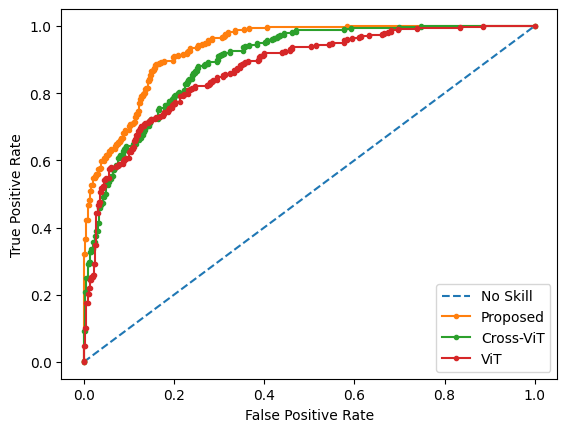

In [54]:
# from torch import rand, randint
# from torchmetrics.classification import BinaryROC
# preds = torch.Tensor(y_pred)
# target = torch.Tensor(y_true_test)
# print(type(preds))
# metric = BinaryROC()
# metric.update(preds, target)
# fig_, ax_ = metric.plot(score=True)



import matplotlib.pyplot as plt
# roc curve and auc
# from sklearn.datasets import make_classification
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
 
# generate 2 class dataset
# X, y = make_classification(n_samples=1000, n_classes=2, random_state=1)
# # split into train/test sets
# trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)
# # generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_true_test))]
# # fit a model
# model = LogisticRegression(solver='lbfgs')
# model.fit(trainX, trainy)
# # predict probabilities
# lr_probs = model.predict_proba(testX)
# # keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# calculate scores
# ns_auc = roc_auc_score(y_true_test, ns_probs)
# lr_auc = roc_auc_score(y_true_test, y_pred)
# summarize scores
# print('No Skill: ROC AUC=%.3f' % (ns_auc))
# print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_true_test, ns_probs)
cvitmask_fpr, cvitmask_tpr, _ = roc_curve(y_true_test, y_pred[:660])
cvit_fpr, cvit_tpr, _ = roc_curve(y_true_test, y_pred[660:1320])
vit_fpr, vit_tpr, _ = roc_curve(y_true_test, y_pred[1320:1980])
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(cvitmask_fpr, cvitmask_tpr, marker='.', label='Proposed')
plt.plot(cvit_fpr, cvit_tpr, marker='.', label='Cross-ViT')
plt.plot(vit_fpr, vit_tpr, marker='.', label='ViT')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.savefig('roc/'+'roc'+'.eps', format='eps')
plt.show()